In [1]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

input_data_ordered_raw =  pd.read_csv('rnap_scanned_over_ecoli_genome100k.csv')
sequences = input_data_ordered_raw['seq'].tolist()

In [2]:
input_data_ordered_raw.head()

,Unnamed: 0,val,seq,left,right,ori,contig
0,0,23.9083,CTATTACCTGCCCACGGTAAAGGCGTTCTGGTTGCCCTACG,3695629,3695669,+,MG1655.fa
1,1,23.5831,TTTCTGCCCGCGGCCTGGCAATTGATACCGCCTTGCCATCG,1109059,1109099,+,MG1655.fa
2,2,23.4205,TTTTTACACGCCTTGCGTAAAGCGGCACGGCGCGGGGTGCG,822216,822256,-,MG1655.fa
3,3,23.4098,TTGCTGCCTGGCCGATGGTCTATGCCGCTGCGTTCTCCGGC,772478,772518,+,MG1655.fa
4,4,23.3640,CTTTTACACGCAAAATGCCGTCACGTTCACGGGTCTGGGCT,2748531,2748571,+,MG1655.fa


## Randomly sample vals and seqs to prevent data imbalance

In [3]:
input_data_ordered_raw[['val','seq']].head()

,val,seq
0,23.9083,CTATTACCTGCCCACGGTAAAGGCGTTCTGGTTGCCCTACG
1,23.5831,TTTCTGCCCGCGGCCTGGCAATTGATACCGCCTTGCCATCG
2,23.4205,TTTTTACACGCCTTGCGTAAAGCGGCACGGCGCGGGGTGCG
3,23.4098,TTGCTGCCTGGCCGATGGTCTATGCCGCTGCGTTCTCCGGC
4,23.3640,CTTTTACACGCAAAATGCCGTCACGTTCACGGGTCTGGGCT


In [4]:
# normally sample high value seqs more
# https://stackoverflow.com/questions/33160367/numpy-how-to-generate-a-normally-distributed-set-of-integers
bi = np.random.binomial(n=10000, p=0.01, size=1000)


In [5]:
num_sample = 40000   # number of training samples
test_size = 10000    # number of test samples

binomial_probability_parameter = 0.5

#index_random_sample_training_data = np.random.randint(100000,size=(9000))
index_random_sample_training_data = np.random.binomial(n=100000, p=binomial_probability_parameter, size=num_sample)
input_data_raw = input_data_ordered_raw[['val','seq']].loc[index_random_sample_training_data]
print(input_data_raw.head())

#index_random_sample_test_data = np.random.randint(100000,size=(1000))
index_random_sample_test_data = np.random.binomial(n=100000, p=binomial_probability_parameter, size=test_size)
input_data_raw_test = input_data_ordered_raw[['val','seq']].loc[index_random_sample_test_data]

print(input_data_raw_test.head())

           val                                        seq
49783  20.1916  TCGTTGCCTGCGGCAGGGTAAATTCGACTTCACTCTGCCAG
49929  20.1899  AGATTAAATGGTTAAATTCTGCTTGCTGCGCTTTGGCCTCG
49884  20.1904  TTTCAGCAGCTTCTTCCGCACGGTCTTCACCGCTCGCCACG
50157  20.1873  TGTTAAAAGGGGATGTGTTATCCAGCACCGCCTGAATCACA
50140  20.1875  GAAATCGCCAGCCACTTGCGCCGGATTTGCCGCGCCTGCCA
           val                                        seq
50064  20.1883  CCCCTACATAGTGGGAATAGTAAGACCAGTTAGTCCCGAAC
49965  20.1894  CGCAACCAGTTTCTCGATGCCTCTCTGACGCTGGCGCGCCA
50170  20.1871  CCCGGCGATGGTCAATGAAGGCACTTTTCGCGCTGACCTGC
50068  20.1883  GCTGACCAAAACCTGGGAAACCATTCACGGCGCGCCCGTTG
50031  20.1886  ACGTCGCCTGAACATGAATCTCTCCTGAAGCGCTGACTTCG


## Make positive and negative Labels

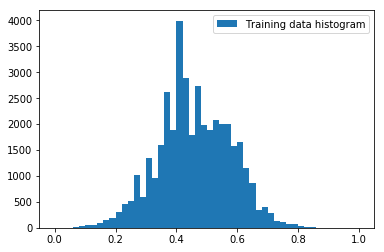

In [6]:
# positive and negative labels
# normalize the following between 0 and 1
pos_labels = np.array(input_data_raw['val'][0:num_sample])
pos_labels = (pos_labels-min(pos_labels))/(max(pos_labels)-min(pos_labels))

# test positive and negative labels
test_pos_labels = np.array(input_data_raw_test['val'][0:test_size])
test_pos_labels = (test_pos_labels-min(test_pos_labels))/(max(test_pos_labels)-min(test_pos_labels))

plt.hist(pos_labels,bins=50,label='Training data histogram')
plt.legend()
plt.show()
# assigned random values to negative examples

In [7]:
sequences = np.array(sequences)

pos = []
pos = list(sequences[index_random_sample_training_data])

test_pos = []
test_pos = list(sequences[index_random_sample_test_data])

pos = np.array(pos)
test_pos = np.array(test_pos)

seq_length = len(pos[0])

## One-hot encoding

In [8]:
temp_pos = []
temp_pos_test = []
for reshape_index in range(len(pos)):
    temp_pos.append(list(pos[reshape_index]))

for reshape_test_index in range(len(test_pos)):
    temp_pos_test.append(list(test_pos[reshape_test_index]))
    
pos = temp_pos
test_pos = temp_pos_test

In [9]:
pos = np.array(pos)
test_pos = np.array(test_pos)

In [10]:
pos_tensor = np.zeros(list(pos.shape) + [4])

test_pos_tensor = np.zeros(list(test_pos.shape) + [4])

base_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

#naive one-hot encoding
for row in range(num_sample):
    for col in range(seq_length):
        pos_tensor[row,col,base_dict[pos[row,col]]] = 1
        if(row<test_size):
            test_pos_tensor[row,col,base_dict[test_pos[row,col]]] = 1

print('Positive sample matrix shape: {}'.format(pos.shape))
# this should be a 3D tensor with shape: (samples, steps, input_dim)
print('Positive sample tensor shape: {}'.format(pos_tensor.shape))

X = pos_tensor
y = pos_labels

X_test = test_pos_tensor
y_test = test_pos_labels

print('Training set shape: {}'.format(X.shape))
print('Training set label shape: {}'.format(y.shape))
print('\nOne-hot encoding looks like:\n {}'.format(X[0,0:10,:]))

Positive sample matrix shape: (40000, 41)
Positive sample tensor shape: (40000, 41, 4)
Training set shape: (40000, 41, 4)
Training set label shape: (40000,)

One-hot encoding looks like:
 [[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


# Define error metrics

In [11]:
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

## Define Models

In [12]:
#here comes the deep learning part
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Dropout
from keras.activations import relu
from keras.layers.pooling import MaxPooling1D
from keras.optimizers import SGD, Adam

#sanity check for dimensions
#print('Shape of the output of first layer: {}'.format(model.predict_on_batch(pos_tensor[0:1,:,:]).shape))

Using TensorFlow backend.


In [13]:

model = Sequential()
#model.add(Conv1D(1, 19, padding='same', input_shape=(seq_length, 4), activation='relu'))
model.add(Conv1D(20, 41, padding='same', input_shape=(seq_length, 4), activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(10, 20, padding='same', input_shape=(seq_length, 4), activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

#model.compile(loss='mean_squared_error',optimizer='adam', metrics=['mean_squared_error',r_square])
#model.compile(loss='mean_squared_error',optimizer=sgd, metrics=[rmse,r_square])
model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.0001), metrics=[rmse,r_square])

#history = model.fit(X, y, validation_split=0.2, epochs=50)  # starts training
history = model.fit(X, y, validation_split=0.3, epochs=100)  # starts training



Train on 28000 samples, validate on 12000 samples
Epoch 1/100
28000/28000 [==============================] - 4s 145us/step - loss: 0.0246 - rmse: 0.1218 - r_square: -0.8687 - val_loss: 0.0122 - val_rmse: 0.0843 - val_r_square: 0.1149
Epoch 2/100
28000/28000 [==============================] - 4s 132us/step - loss: 0.0137 - rmse: 0.0894 - r_square: -0.0203 - val_loss: 0.0071 - val_rmse: 0.0568 - val_r_square: 0.4985
Epoch 3/100
28000/28000 [==============================] - 4s 133us/step - loss: 0.0094 - rmse: 0.0713 - r_square: 0.3107 - val_loss: 0.0044 - val_rmse: 0.0371 - val_r_square: 0.7029
Epoch 4/100
28000/28000 [==============================] - 4s 134us/step - loss: 0.0066 - rmse: 0.0585 - r_square: 0.5153 - val_loss: 0.0030 - val_rmse: 0.0266 - val_r_square: 0.8028
Epoch 5/100
28000/28000 [==============================] - 4s 137us/step - loss: 0.0053 - rmse: 0.0519 - r_square: 0.6158 - val_loss: 0.0023 - val_rmse: 0.0241 - val_r_square: 0.8454
Epoch 6/100
28000/28000 [========

28000/28000 [==============================] - 4s 156us/step - loss: 4.6682e-04 - rmse: 0.0153 - r_square: 0.9657 - val_loss: 6.6783e-04 - val_rmse: 0.0114 - val_r_square: 0.9581
Epoch 45/100
28000/28000 [==============================] - 4s 150us/step - loss: 4.6647e-04 - rmse: 0.0153 - r_square: 0.9657 - val_loss: 6.1131e-04 - val_rmse: 0.0100 - val_r_square: 0.9622
Epoch 46/100
28000/28000 [==============================] - 4s 139us/step - loss: 4.5136e-04 - rmse: 0.0151 - r_square: 0.9666 - val_loss: 6.2524e-04 - val_rmse: 0.0103 - val_r_square: 0.9612
Epoch 47/100
28000/28000 [==============================] - 4s 145us/step - loss: 4.6375e-04 - rmse: 0.0153 - r_square: 0.9657 - val_loss: 5.6680e-04 - val_rmse: 0.0077 - val_r_square: 0.9658
Epoch 48/100
28000/28000 [==============================] - 4s 143us/step - loss: 4.4433e-04 - rmse: 0.0150 - r_square: 0.9672 - val_loss: 5.6882e-04 - val_rmse: 0.0078 - val_r_square: 0.9657
Epoch 49/100
28000/28000 [===========================

Epoch 87/100
28000/28000 [==============================] - 4s 139us/step - loss: 3.9862e-04 - rmse: 0.0139 - r_square: 0.9706 - val_loss: 5.6619e-04 - val_rmse: 0.0077 - val_r_square: 0.9656
Epoch 88/100
28000/28000 [==============================] - 4s 139us/step - loss: 3.8728e-04 - rmse: 0.0137 - r_square: 0.9717 - val_loss: 6.0355e-04 - val_rmse: 0.0097 - val_r_square: 0.9626
Epoch 89/100
28000/28000 [==============================] - 4s 139us/step - loss: 3.9796e-04 - rmse: 0.0139 - r_square: 0.9708 - val_loss: 5.6927e-04 - val_rmse: 0.0077 - val_r_square: 0.9653
Epoch 90/100
28000/28000 [==============================] - 4s 138us/step - loss: 3.8221e-04 - rmse: 0.0137 - r_square: 0.9719 - val_loss: 5.6445e-04 - val_rmse: 0.0072 - val_r_square: 0.9658
Epoch 91/100
28000/28000 [==============================] - 4s 139us/step - loss: 3.8089e-04 - rmse: 0.0136 - r_square: 0.9720 - val_loss: 5.8814e-04 - val_rmse: 0.0084 - val_r_square: 0.9639
Epoch 92/100
28000/28000 [==============

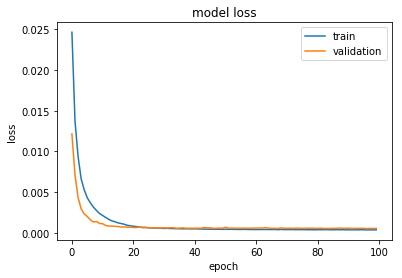

In [14]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [15]:
history.history.keys()

dict_keys(['val_loss', 'val_rmse', 'val_r_square', 'loss', 'rmse', 'r_square'])

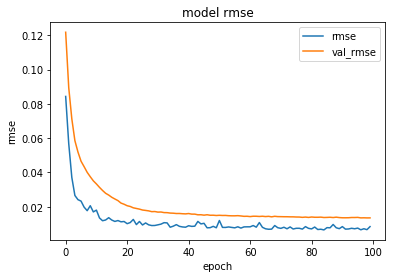

In [16]:
plt.plot(history.history['val_rmse'])
plt.plot(history.history['rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['rmse', 'val_rmse'], loc='upper right')
plt.show()


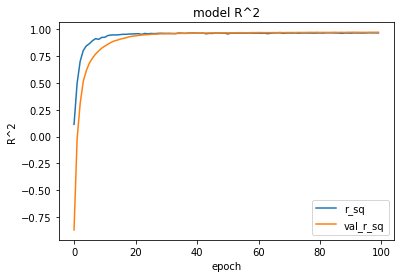

In [17]:
plt.plot(history.history['val_r_square'])
plt.plot(history.history['r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['r_sq', 'val_r_sq'], loc='lower right')
plt.show()


In [19]:
#have a look at the filter
convlayer = model.layers[0]
weights = convlayer.get_weights()[0].squeeze()
print('Convolution parameter shape: {}'.format(weights.shape))

num2seq = ['A','C','G','T']

#''.join([num2seq[np.argmax(weights[i,:])] for i in range(weights.shape[0])])
#test_pred = ''.join([num2seq[np.argmax(weights[i,:])] for i in range(weights.shape[0])])

Convolution parameter shape: (41, 4, 20)


## Make predictions

In [20]:
model_prediction = model.predict(X_test)

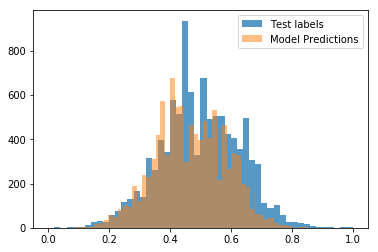

In [21]:
plt.hist(test_pos_labels,bins=50,alpha=0.75,label='Test labels')
plt.hist(model_prediction,bins=50,alpha=0.5,label='Model Predictions')
plt.legend()
plt.show()

In [22]:
pos_model_prediction = model.predict(test_pos_tensor)

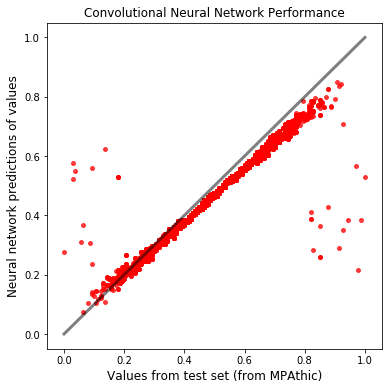

In [23]:
from pylab import rcParams
rcParams['xtick.labelsize'] = 10 
rcParams['ytick.labelsize'] = 10 
rcParams['figure.figsize'] = 6, 6

plt.scatter(y_test,pos_model_prediction,s=15,alpha=0.75,color='red')
plt.plot([0,1],alpha=0.5,linewidth=3,color='black')
plt.ylabel('Neural network predictions of values',fontsize=12)
plt.xlabel('Values from test set (from MPAthic)',fontsize=12)
plt.title('Convolutional Neural Network Performance')
plt.show()


In [24]:
import tensorflow.keras.backend as K
import tensorflow as tf

K.set_session(tf.Session(graph=model.output.graph)) 
init = tf.global_variables_initializer() 
K.get_session().run(init)

def compute_salient_bases(model, x):
  input_tensors = [model.input]
  gradients = model.optimizer.get_gradients(model.output[0][0], model.input)
  
  compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
  x_value = np.expand_dims(x, axis=0)

  gradients = compute_gradients([x_value])[0][0]
  sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
  return sal


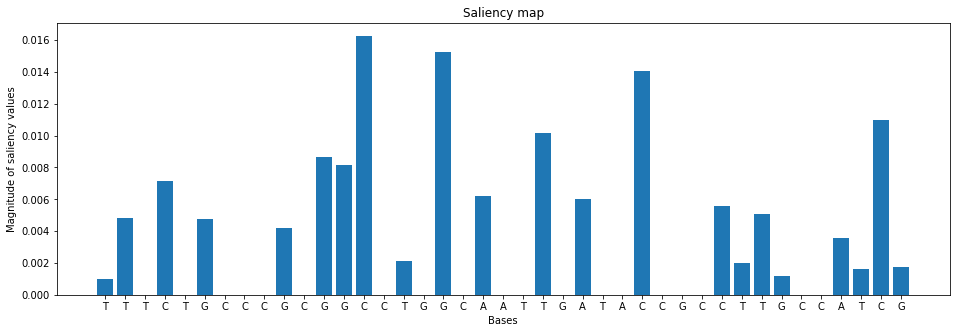

In [28]:
sequence_index = 1
sal = compute_salient_bases(model, X_test[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
#[barlist[i].set_color('C1') for i in range(5,17)]
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map');
plt.show()